In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
import requests



Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Get global ncov tree and convert to Bio Phylo format

In [8]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
tree_json = requests.get(tree_url).json()
tree = json_to_tree(tree_json)

In [15]:
for node in tree.find_clades(terminal=False):
    
    # only consider mutations on branches that give rise to a clade of at least 10 tips
    if len(node.get_terminals()) >=10:
        #just use nucleotide mutations because this includes all syn and nonsyn 
        if hasattr(node, 'branch_attrs'):
            if "nuc" in node.branch_attrs["mutations"]:
                if 'C28253T' in node.branch_attrs["mutations"]['nuc']:
                    print(node.branch_attrs["mutations"])

{'ORF1a': ['S3675-', 'G3676-', 'F3677-'], 'nuc': ['G174T', 'T11288-', 'C11289-', 'T11290-', 'G11291-', 'G11292-', 'T11293-', 'T11294-', 'T11295-', 'T11296-', 'C28253T']}
{'nuc': ['C28253T']}
{'nuc': ['C9857T', 'C28253T']}
{'ORF1a': ['P271L', 'V757F', 'P2260S', 'T3255I'], 'ORF1b': ['T216A', 'R2613H'], 'S': ['Q675H', 'Q677H'], 'nuc': ['C1077T', 'G2534T', 'C3736T', 'C7043T', 'C8980T', 'C10029T', 'A14113G', 'G23587C', 'G23593T', 'C24382T', 'C25665T', 'C28253T']}
{'N': ['A119S', 'M234I'], 'nuc': ['C11824T', 'A12964G', 'C28253T', 'G28628T', 'G28975T', 'C29754T']}


In [ ]:
#node.__dict__

Want to see if a high number of S1 mutations is preceded by a specific other mutation.

Find average number of S1 mutations that occur AFTER certain mutation

1. Find all mutations that occurred on tree (set)
2. Walk through tree and, if mutation occurred on branch, count S1 mutations in descendents

In [9]:
# 1: find all mutations that happened on internal branchs of tree
# one instance where a node has {'S': ['E484K']} but no nucleotide mutations??

all_mutations = []

for node in tree.find_clades(terminal=False):
    
    # only consider mutations on branches that give rise to a clade of at least 10 tips
    if len(node.get_terminals()) >=10:
        #just use nucleotide mutations because this includes all syn and nonsyn 
        if hasattr(node, 'branch_attrs'):
            if "nuc" in node.branch_attrs["mutations"]:
                all_mutations += node.branch_attrs["mutations"]['nuc']


all_mutations_unique = list(set(all_mutations))    


In [10]:
# Add node attribute s1_descendents which counts the number of s1 mutations that occur in all descendents of a node

for node in tree.find_clades(order= "postorder"): 
    node_s1_muts = 0
    if hasattr(node, 'branch_attrs'):
        if "nuc" in node.branch_attrs["mutations"]:
            for nuc_mut in node.branch_attrs["mutations"]['nuc']:
                nuc_mut_pos = int(nuc_mut[1:-1])
                s1_pos = range(21599,23617)
                if nuc_mut_pos in s1_pos:
                    node_s1_muts+=1

    if node.is_terminal():
        # Store number of s1 mutations of each terminal node
        node.s1_descendents = node_s1_muts
        node.num_descendents = 0
        
    else:   
        # For each internal node, sum the number of s1 mutations in its immediate
        # children. Since we are walking through the tree from tip to root, 
        # each child node will always be counted before its parent node
        node.s1_descendents = sum([child.s1_descendents for child in node.clades])
        # number of descendents is 1 for each child, plus the already calculated number descendents of those children
        node.num_descendents = (sum([1 for child in node.clades]) + 
                                sum([child.num_descendents for child in node.clades]))
        

In [11]:
# 2: For each possible mutation, 
# walk through tree to find nodes where these muts happened. Then count S1 muts in descendents
# and divide this by the number of descendents to get (number of S1 muts per descendent)

# initiate dictionary where keys are all observed mutations at internal nodes 
# and values are lists of number of S1 mutations per descendent, which occur after (key) mutation, 
# for each time (key) mutation is observed
nums1_following_mutation = {}

for mut in all_mutations_unique:
    mut_future_s1_mut_counts = []
    for node in tree.find_clades(terminal=False):
        
        # only consider mutations on branches that give rise to a clade of at least 10 tips
        if len(node.get_terminals()) >=10:
            if hasattr(node, 'branch_attrs'):
                if "nuc" in node.branch_attrs["mutations"]:
                    if mut in node.branch_attrs["mutations"]['nuc']:
                        s1_muts_per_descendent = node.s1_descendents/node.num_descendents
                        mut_future_s1_mut_counts.append(s1_muts_per_descendent)
    nums1_following_mutation[mut] = mut_future_s1_mut_counts
    


Find the mean number of S1 mutations that follow each observed mutation and plot a distribution

    mutation  mean_s1muts_after  num_occurrences
28   T22917G           1.679726                5
466  C10029T           0.548367                6
395  C28253T           0.526701                5
276  T11290-           0.459850                8
313  T11295-           0.459850                8
343  G11292-           0.459850                8
456  T11296-           0.459850                8
651  C11289-           0.459850                8
685  G11291-           0.459850                8
693  T11288-           0.459850                8


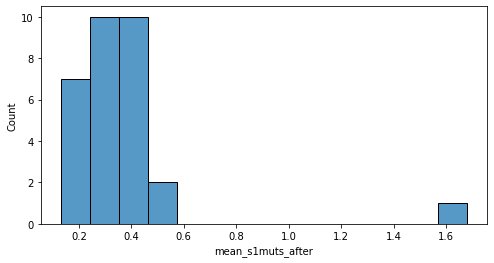

In [18]:
#initialize list of dictionaries to store mutation and average number of S1 muts per descendent that follow
avg_s1_following_mutation = []

for k,v in nums1_following_mutation.items():
    num_occurrences = len(v)
    s1muts_mean = sum(v)/len(v)
    avg_s1_following_mutation.append({'mutation': k, 'mean_s1muts_after': s1muts_mean, 
                                      'num_occurrences':num_occurrences})
    
avg_s1_following_mutation_df = pd.DataFrame(avg_s1_following_mutation)

# print(avg_s1_following_mutation_df.nlargest(10, 'mean_s1muts_after'))
print(avg_s1_following_mutation_df[avg_s1_following_mutation_df['num_occurrences']>3].nlargest(10, 'mean_s1muts_after'))

fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.histplot(x = 'mean_s1muts_after', data = avg_s1_following_mutation_df[avg_s1_following_mutation_df['num_occurrences']>3])

# 'T22917G' is 'L452R'
# 'C10029T' is ORF1a 'T3255I'
# 'C28253T' is Orf8 SYN mut

The above doesn't work and probably I shouldn't have expected it to

New method:

For each clade:
1. Find the number of S1 mutations that occurred root-to-clade (given by nextstrain 'S1_mutations') attribute
2. For every possible observed mutation, mark as 0 or 1 in the root-to-clade history of the clade

Then, take the clades with the higest numbers of S1 mutations and find the proportion of them that have each possible mutation. Plot the distribution

In [77]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

# initialize list to store dictionaries containing information for each clade 
# (num S1 mutations and whether not each possible mutation occurred)
clade_mutation_binary_history = []


for node in tree.find_clades(terminal=False):

    if "S1_mutations" in node.node_attrs:
        #initialize dictionary entry (which will be row in df) for clade
        clade_row = {'clade': node.name, 'num_s1_muts': node.node_attrs["S1_mutations"]["value"]}
        
        for mut in all_mutations_unique:
            clade_row[mut] = False
            node_path = get_parent(tree, node)
            for parent in node_path:
                if hasattr(parent, 'branch_attrs'):
                    if "nuc" in parent.branch_attrs["mutations"]:
                        if mut in parent.branch_attrs["mutations"]["nuc"]:
                            clade_row[mut] = True
                        
        clade_mutation_binary_history.append(clade_row)
        
clade_mut_history_df = pd.DataFrame(clade_mutation_binary_history)
                    

Take all clades with at least 6 S1 mutations (root-to-clade) and find the proportion of these clades where mutation X happened along the path (where X is each possible mutation). Plot the distribution

Text(0.5, 0, 'frequency of mutation within S1-mutation-enriched clades')

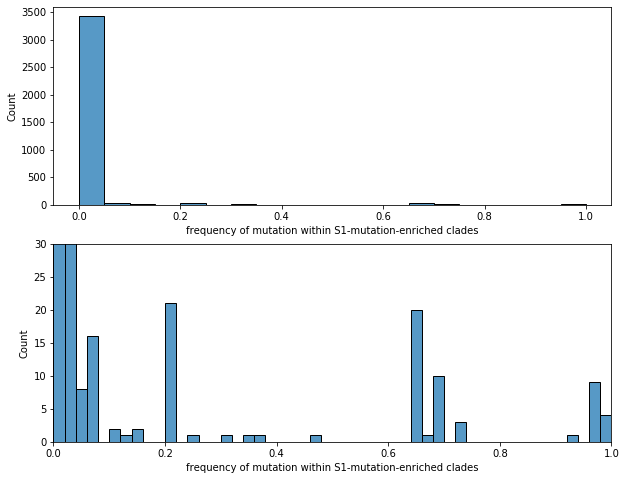

In [167]:
# initialize list of dictionaries containing info about the proportion of clades with 
# at least (cutoff) S1 mutations and a given mutation
proportion_of_highs1clades_with_mut = []

cutoff_values = [6]
for cutoff in cutoff_values:
    cutoff_df = clade_mut_history_df[clade_mut_history_df['num_s1_muts']>=cutoff]
    num_clades = len(cutoff_df)
    for observed_mut in all_mutations_unique:
        observed_mut_count = len(cutoff_df[cutoff_df[observed_mut]==True])
        observed_mut_freq = observed_mut_count/num_clades

        proportion_of_highs1clades_with_mut.append({'cutoff': cutoff, 'mutation': observed_mut, 
                                                    'frequency': observed_mut_freq})


proportion_of_highs1clades_with_mut_df = pd.DataFrame(proportion_of_highs1clades_with_mut)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8))
sns.histplot(x = 'frequency', data = proportion_of_highs1clades_with_mut_df, ax=ax1, bins=20)
sns.histplot(x = 'frequency', data = proportion_of_highs1clades_with_mut_df, bins=50, ax=ax2)
ax2.set_ylim(0,30)
ax2.set_xlim(0.0,1.0)
ax1.set_xlabel('frequency of mutation within S1-mutation-enriched clades')
ax2.set_xlabel('frequency of mutation within S1-mutation-enriched clades')

# print(proportion_of_highs1clades_with_mut_df[proportion_of_highs1clades_with_mut_df['frequency']!=0.0])


Find the mutations that occur at highest frequency within the clades with at least 6 S1 mutations

In [153]:
top_hits_df = proportion_of_highs1clades_with_mut_df.nlargest(50, 'frequency').reset_index()

Find the location and type (syn or nonsyn) of the top mutations

In [170]:
#initialize list for new df with locationa and type info
top_muts = []

for k,v in top_hits_df.iterrows():
    nt_mut = v['mutation']
    
    #convert to 0-based for biopython
    nt_pos = int(nt_mut[1:-1])-1
    #set gene to noncoding, to be overwritten if nt_pos falls in gene
    gene = 'noncoding'
    #set mut_type default to syn, to be overwritten if mutation is nonsyn (unless deletion)
    if nt_mut[-1] == "-":
        mut_type = 'del'
    else:
        mut_type = 'syn'
    #set default aa_mut to None
    aa_mut = None
    for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
        for feature in record.features:
            if feature.type == 'CDS':
                #find what gene the mut is in
                if nt_pos in feature.location:
                    gene = feature.qualifiers['gene'][0]
                    if nt_mut[-1] == "-":
                        mut_type = 'del'
                        
                    else:
                        #get nt sequence of the gene
                        gene_nt = feature.location.extract(record.seq)
                        gene_nt_mutated = gene_nt.tomutable()
                        gene_nt_mutated[nt_pos-feature.location.start] = nt_mut[-1]

                        #find what codon mutation occurred in
                        mut_codon = int((nt_pos-feature.location.start)/3)
                        #find the nt sequence and amino acid of codon before and after mut
                        codon_nt = gene_nt[mut_codon*3:mut_codon*3+3]
                        codon_aa = codon_nt.translate()
                        mut_codon_nt = gene_nt_mutated[mut_codon*3:mut_codon*3+3]
                        mut_codon_aa = Seq(str(mut_codon_nt)).translate()
                        #find whether mut was syn or nonsyn
                        if codon_aa != mut_codon_aa:
                            mut_type = 'nonsyn' 
                            #make mut codon 1-based
                            codon_pos = mut_codon +1
                            #need to adjust s1 and s2 to spike numbering
                            if gene == 'S1':
                                adjust_for_sigpep = codon_pos + 12
                                aa_mut = f'{codon_aa}{adjust_for_sigpep}{mut_codon_aa}'
                            elif gene == 'S2':
                                adjust_for_sigpep_and_s1 = codon_pos + 12 + 673
                                aa_mut = f'{codon_aa}{adjust_for_sigpep_and_s1}{mut_codon_aa}'
                                
                            else:
                                aa_mut = f'{codon_aa}{codon_pos}{mut_codon_aa}'
                        
    top_muts.append({'cutoff': v['cutoff'], 'mutation': v['mutation'], 
                     'mut_type': mut_type, 'gene': gene, 'aa_mut': aa_mut,
                     'frequency': v['frequency']})
    
top_muts_df = pd.DataFrame(top_muts)



In [171]:
top_muts_df.to_csv('top_muts_s1enrichedclades.tsv',sep='\t')